# PROGRAM FDinplane
2-d rectangle o-4 stress velocity inplane

Stefan Nielsen - June 2018

import standard python libraries:

In [12]:
from google.colab import files
uploaded = files.upload()

Saving FDfpar.py to FDfpar (2).py
Saving FDarrays.py to FDarrays (2).py


In [13]:
%pip install -q "ipympl==0.9.6" "ipywidgets==8.1.3" "matplotlib==3.8.4"
from google.colab import output
output.enable_custom_widget_manager()

In [23]:
# Stefan Nielsen 2018 - various lib import:
#%matplotlib inline
#%matplotlib notebook
#%config InlineBackend.figure_format = 'svg'
import os
import time
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
#matplotlib.interactive(True)
from pylab import plot, xlabel, ylabel
from pylab import *
#from scipy import arange
#from IPython import display
from matplotlib import animation, rc
import matplotlib.ticker as ticker
from importlib import reload
#####

initialise parameters and arrays, importing from local files:

In [24]:
from FDfpar import *       #
from FDarrays import *     #

mu[:,:]=28.e9
lam[:,:]=28.e9
rho[:,:]=2700.
rn=9./8.;rnn=-1/24.;
def init(v1,v2,s11,s22,s12):
    v1[:,:]=0;v2[:,:]=0;s11[:,:]=0;s22[:,:]=0;s12[:,:]=0;
nxs=30;nys=2;

define functions:

In [25]:
def stress_o4(s11,s22,s12):
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            s11[j,i]=  s11[j,i] + (dt/dx) * (                   \
            (lam[j,i]+2*mu[j,i]) *                              \
            (rn*(v1[j,i]-v1[j,i-1])+rnn*(v1[j,i+1]-v1[j,i-2]))  \
            +lam[j,i] *                                         \
            (rn*(v2[j+1,i]-v2[j,i])+rnn*(v2[j+2,i]-v2[j-1,i])) )
            #
            s22[j,i]=s22[j,i]+ (dt/dx)*(                        \
            (lam[j,i]+2*mu[j,i]) *                              \
            (rn*(v2[j+1,i]-v2[j,i])+rnn*(v2[j+2,i]-v2[j-1,i]))  \
            +lam[j,i] *                                         \
            (rn*(v1[j,i]-v1[j,i-1])+rnn*(v1[j,i+1]-v1[j,i-2])  ) )
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            s12[j,i]=  s12[j,i] + mu[j,i]*(dt/dx)*(               \
            (rn*(v1[j,i]-v1[j-1,i])+rnn*(v1[j+1,i]-v1[j-2,i]))+    \
            (rn*(v2[j,i+1]-v2[j,i])+rnn*(v2[j,i+2]-v2[j,i-1]))  )

In [26]:
def stress_o2(s11,s22,s12):
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            s11[j,i]=  s11[j,i] + (dt/dx) * (                   \
            (lam[j,i]+2*mu[j,i]) *(v1[j,i]-v1[j,i-1])                                 \
            +lam[j,i]*(v2[j+1,i]-v2[j,i]) )
            #
            s22[j,i]=s22[j,i]+ (dt/dx)*(                        \
            (lam[j,i]+2*mu[j,i])*(v2[j+1,i]-v2[j,i])                                 \
            + lam[j,i]*(v1[j,i]-v1[j,i-1])  )
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            s12[j,i]=  s12[j,i] + mu[j,i]*(dt/dx)*(            \
            (v1[j,i]-v1[j-1,i])+(v2[j,i+1]-v2[j,i])     )

In [27]:
def vel_o4(v1,v2):
    for i in range(2,nx-2):
        for j in range(2,ny-2):
            v1[j,i]= v1[j,i]+(1.-diss)*(dt/(dx*rho[j,i]))*(          \
             rn*(s11[j,i+1]-s11[j,i])+rnn*(s11[j,i+2]-s11[j,i-1])     \
            +rn*(s12[j+1,i]-s12[j,i])+rnn*(s12[j+2,i]-s12[j-1,i])   )
            #
            v2[j,i]= v2[j,i]+(1.-diss)*(dt/(dx*rho[j,i]))*(            \
             rn*(s22[j,i]-s22[j-1,i])+rnn*(s22[j+1,i]-s22[j-2,i])     \
            +rn*(s12[j,i]-s12[j,i-1])+rnn*(s12[j,i+1]-s12[j,i-2]) )

In [28]:
def vel_o2(v1,v2):
    for i in [1,nx-2]:
        for j in [1,ny-2]:
            v1[j,i]= v1[j,i]+(1.-diss)*(dt/(dx*rho[j,i]))*(            \
             (s11[j,i+1]-s11[j,i]) + (s12[j+1,i]-s12[j,i]) )
            #
            v2[j,i]= v2[j,i]+(1.-diss)*(dt/(dx*rho[j,i]))*(            \
             (s22[j,i]-s22[j-1,i]) + (s12[j,i]-s12[j,i-1]) )

In [29]:
def ssource1(s11,s22):
    rf=0.
    rf=(1./tau_s)*exp(-((float(it)*dt-2.*tau_s)/tau_s)**2)
    s22[nys,nxs]=s22[nys,nxs]+rf
    s11[nys,nxs]=s11[nys,nxs]+rf

In [30]:
def plo():
    import time
    mava=np.max(v1)

    fig=plt.figure(figsize=(8,4))
    ax1 = plt.subplot2grid((1,8), (0,0), colspan=7)

    p = ax1.pcolor(v1, cmap=cm.RdBu,vmin=-mava,vmax=mava);
    tim=it*dt
    ax1.set_aspect('equal', adjustable='box')
    fig.suptitle('time=%1.3f' %tim)
    plt.show()

In [33]:
def ssource2(s11,s22):
    # add here an instant dislocation or a propagating crack
    pass

start main time loop:

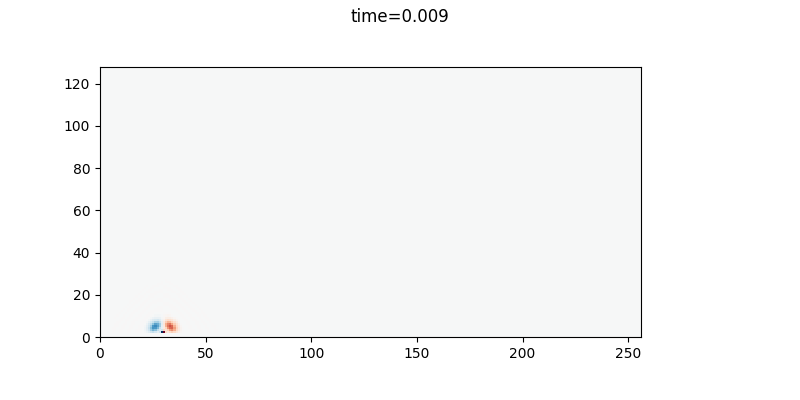

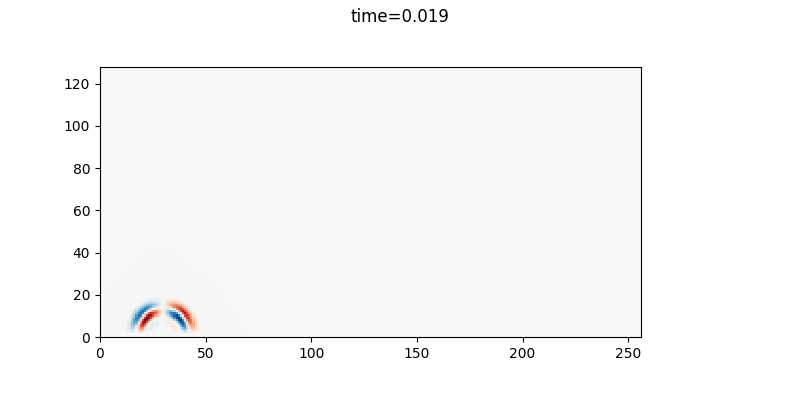

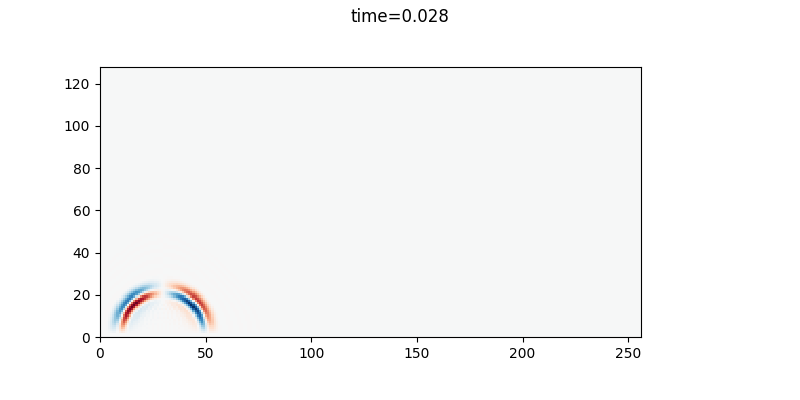

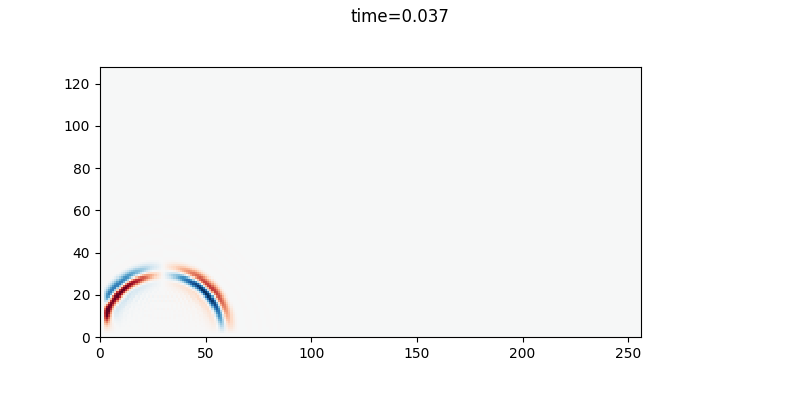

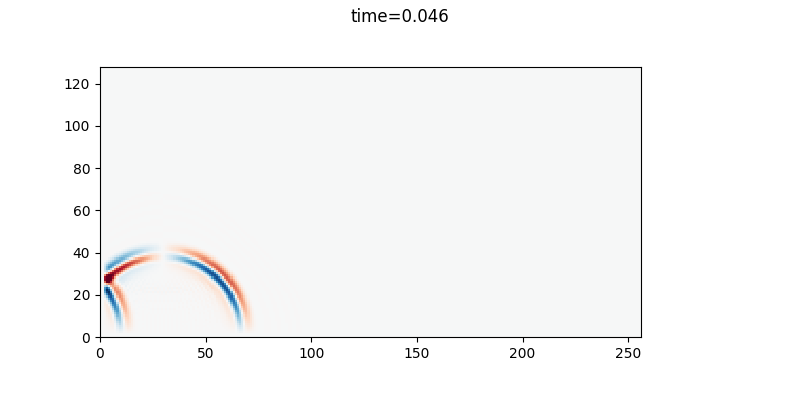

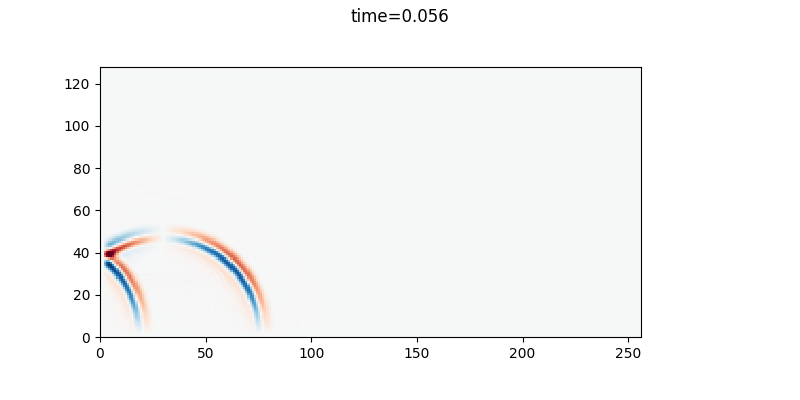

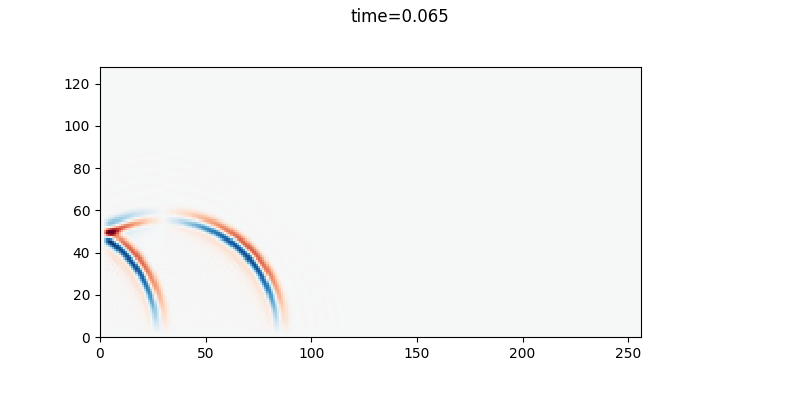

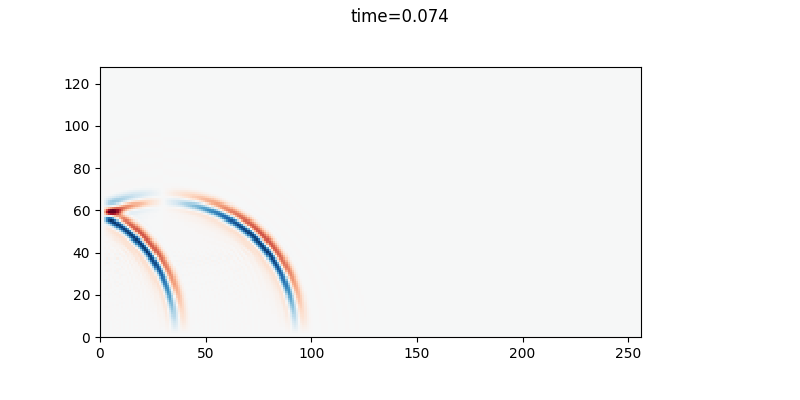

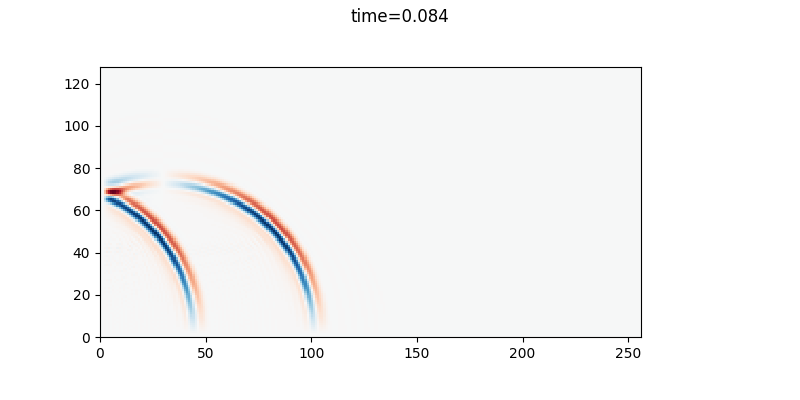

/tmp/ipython-input-451396322.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(8,4))


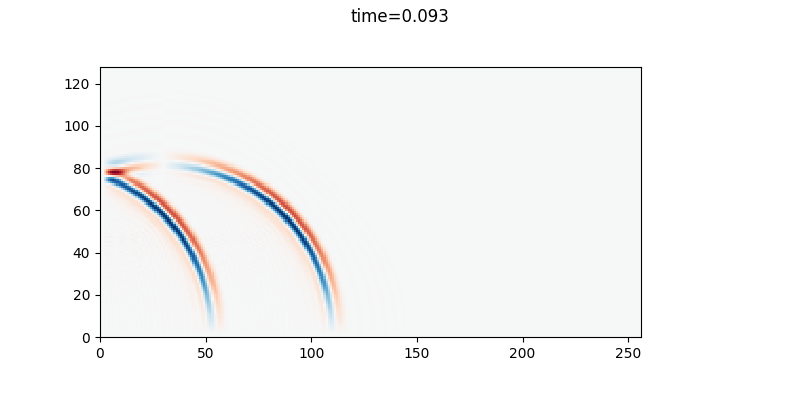

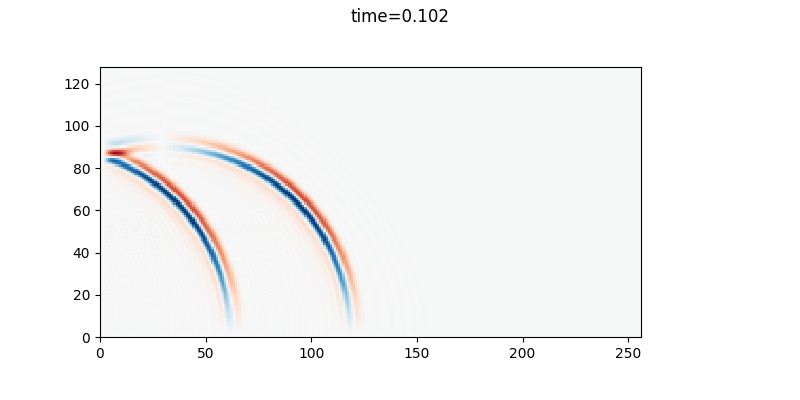

In [32]:
it=0;is1=0
ntime = 350; nos2=30;
startt=time.time()
#
v1s=[]
#
init(v1,v2,s11,s22,s12)
try:
    while(it < ntime):
        it = it+1;
        stress_o4(s11,s22,s12)
        stress_o2(s11,s22,s12)
        ssource1(s11,s22)
        vel_o4(v1,v2)
        vel_o2(v1,v2)
        is1 = is1+1
        if (is1 > nos2):
            plo();
            is1=0
            #print ("it="+str(it)+" — time="+str(round(it*dt,3))+" s")
        v1s.append(v1[63,127])
except KeyboardInterrupt:
    pass

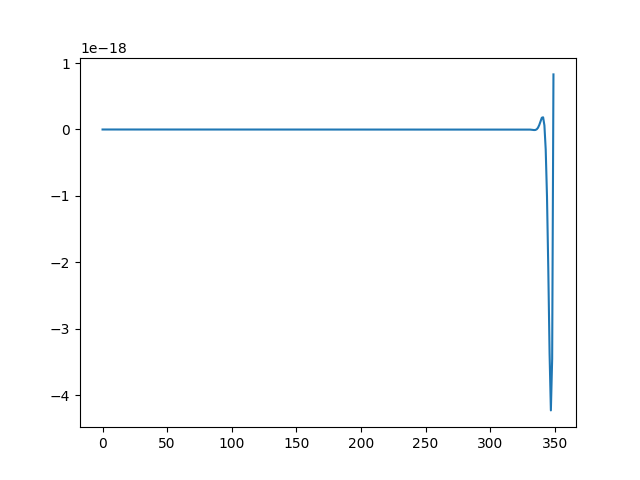

In [34]:
fig,ax=plt.subplots()
ax.plot(v1s)